In [1]:
import motionmapperpy as mmpy
from scipy.signal import cwt, ricker
import wavelet as wl
from cuml import PCA, KMeans
from .processing import *
from src.utils import *
from fishproviz.config.config import BLOCK, ROOT_LOCAL, VIS_DIR
from src.metrics.tank_area_config import *
from src.clustering.clustering import boxplot_characteristics_of_cluster, get_results_filepath
from src.clustering.transitions_cluster import transition_rates, draw_transition_graph
from .utils import *
%matplotlib inline
import matplotlib.pyplot as plt
parameters = mmpy.setRunParameters()
parameters.pcaModes = 3
parameters.samplingFreq = 5
parameters.maxF = 2.5
parameters.minF = 0.01
parameters.omega0 = 5
parameters.projectPath = projectPath
parameters.training_points_of_day = 200
parameters.numProcessors = 16
parameters.method="UMAP"#"TSNE"
parameters.useGPU=0
parameters.training_numPoints = 3000    #% Number of points in mini-trainings.
parameters.trainingSetSize = 5000  #% Total number of training set points to find. 
                                 #% Increase or decrease based on
                                 #% available RAM. For reference, 36k is a 
                                 #% good number with 64GB RAM.

%load_ext autoreload
%autoreload 2 


(ipykernel_launcher.py:377507): Gtk-WARNING **: 13:34:25.041: Locale not supported by C library.
	Using the fallback 'C' locale.


In [2]:
fish_keys = get_camera_pos_keys()
area_f = get_area_functions()
days = get_all_days_of_context()
fk = fish_keys[1]
day = days[6]
area_t = (fk, area_f(fk,day))
 
#X = compute_projections(fk, day, area_t)
#X.shape

In [2]:
#parameters

In [15]:
parameters.useGPU=0
import cupy as cp
x = cp.array([1, 2, 3])
print(x.device)

<CUDA Device 0>


In [2]:
# This creates a project directory structure which will be used to store all motionmappery pipeline
# related data in one place.
os.makedirs(parameters.projectPath,exist_ok=True)
mmpy.createProjectDirectory(parameters.projectPath)

Skipping, path already exists : content/Fish_moves
Skipping, path already exists : content/Fish_moves/Projections
Skipping, path already exists : content/Fish_moves/TSNE_Projections
Skipping, path already exists : content/Fish_moves/TSNE
Skipping, path already exists : content/Fish_moves/UMAP


In [ ]:
compute_all_projections(fish_keys, recompute=True)

In [ ]:
mmpy.subsampled_tsne_from_projections(parameters, parameters.projectPath)

Text(0.5, 0, 'Frames')

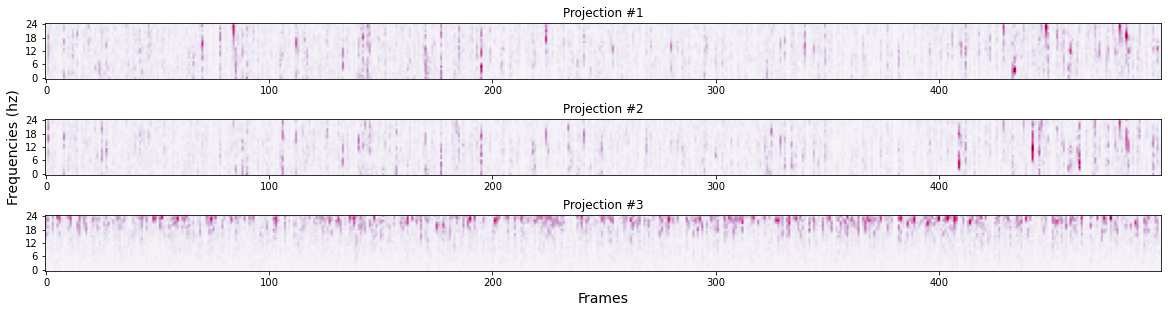

In [18]:
fig, axes = plt.subplots(parameters.pcaModes, 1, figsize=(20,5))

for i, ax in enumerate(axes.flatten()):
    nper = parameters.numPeriods
    ax.imshow(sample_wlets[:500,nper*i:nper*(i+1)].T.get(), cmap='PuRd', origin='lower')
    yticks = range(0, nper, 6)
    ax.set_yticks(yticks)
    #ax.set_yticklabels(['%0.1f'%freqs[j] for j in yticks])
    if i == parameters.pcaModes//2:
        ax.set_ylabel("Frequencies (hz)", fontsize=14)
    ax.set_title('Projection #%i'%(i+1))
ax.set_xlabel('Frames', fontsize=14)


In [6]:
trainx = hdf5storage.loadmat('%s/%s/training_data.mat'%(parameters.projectPath, parameters.method))["trainingSetData"]

In [8]:
KM = KMeans(n_clusters=7)
cluster_labels = KM.fit_predict(trainx)

In [45]:
#X_em = mmpy.run_UMAP(sample_wlets.get(),parameters)

In [11]:
trainy = hdf5storage.loadmat('%s/%s/training_embedding.mat'%(parameters.projectPath, parameters.method))['trainingEmbedding']

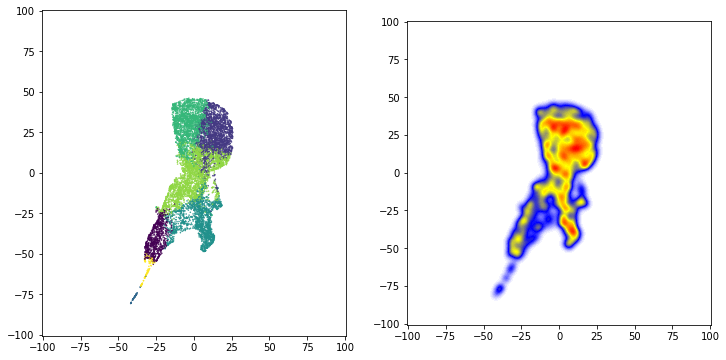

In [9]:
#trainy = X_em
m = np.abs(trainy).max()
sigma=2.0
_, xx, density = mmpy.findPointDensity(trainy, sigma, 511, [-m-20, m+20])

fig, axes = plt.subplots(1, 2, figsize=(12,6))
axes[0].scatter(trainy[:,0], trainy[:,1], marker='.', c=cluster_labels, s=1)
axes[0].set_xlim([-m-20, m+20])
axes[0].set_ylim([-m-20, m+20])
axes[1].imshow(density, cmap=mmpy.gencmap(), extent=(xx[0], xx[-1], xx[0], xx[-1]), origin='lower')

In [12]:
import hdbscan
clusterer = hdbscan.HDBSCAN(min_samples=5,
    min_cluster_size=trainy.shape[0]//100)
cluster_labels = clusterer.fit_predict(trainy)

In [52]:
cluster_labels.max(), cluster_labels.min()

(4, -1)

<AxesSubplot:ylabel='$\\lambda$ value'>

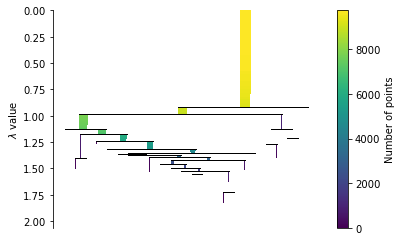

In [9]:
#mmpy.wshed.findWatershedRegions(parameters, minimum_regions=7, endident=f"{BLOCK}*.npy")

In [ ]:
#tsne takes 19 mins
import time
tall = time.time()

import h5py, hdf5storage, pickle, glob
tfolder = parameters.projectPath+'/%s/'%parameters.method

# Loading training data
with h5py.File(tfolder + 'training_data.mat', 'r') as hfile:
    trainingSetData = hfile['trainingSetData'][:].T

# Loading training embedding
with h5py.File(tfolder+ 'training_embedding.mat', 'r') as hfile:
    trainingEmbedding= hfile['trainingEmbedding'][:].T

if parameters.method == 'TSNE':
    zValstr = 'zVals' 
else:
    zValstr = 'uVals'

projectionFiles = glob.glob(parameters.projectPath+'/Projections/*pcaModes.mat')
for i in range(len(projectionFiles)):
    print('Finding Embeddings')
    t1 = time.time()
    print('%i/%i : %s'%(i+1,len(projectionFiles), projectionFiles[i]))

    # Skip if embeddings already found.
    if os.path.exists(projectionFiles[i][:-4] +'_%s.mat'%(zValstr)):
        print('Already done. Skipping.\n')
        continue

    # load projections for a dataset
    projections = hdf5storage.loadmat(projectionFiles[i])['projections']
    print(projections.shape, trainingSetData.shape)
    # Find Embeddings
    zValues, outputStatistics = mmpy.findEmbeddings(projections,trainingSetData,trainingEmbedding,parameters)

    # Save embeddings
    hdf5storage.write(data = {'zValues':zValues}, path = '/', truncate_existing = True,
                    filename = projectionFiles[i][:-4]+'_%s.mat'%(zValstr), store_python_metadata = False,
                    matlab_compatible = True)
    
    # Save output statistics
    with open(projectionFiles[i][:-4] + '_%s_outputStatistics.pkl'%(zValstr), 'wb') as hfile:
        pickle.dump(outputStatistics, hfile)

    del zValues,projections,outputStatistics

print('All Embeddings Saved in %i seconds!'%(time.time()-tall))


Embeddings found in 174.07 seconds.
Finding Embeddings
640/650 : content/Fish_moves/Projections/block1_23520289_front_20210928_060000_pcaModes.mat
(143106, 3) (9750, 75)
Finding Wavelets
	 Calculating wavelets, clock starting.
	 Using GPU #0
	 Done at 0.34 seconds.
Finding Embeddings
	Loading UMAP Model.
	Loaded.
Embeddings found in 172.03 seconds.
Finding Embeddings
641/650 : content/Fish_moves/Projections/block1_23520289_front_20210929_060000_pcaModes.mat
(140506, 3) (9750, 75)
Finding Wavelets
	 Calculating wavelets, clock starting.
	 Using GPU #0
	 Done at 0.34 seconds.
Finding Embeddings
	Loading UMAP Model.
	Loaded.


In [5]:
if parameters.method == 'TSNE':
    zValstr = 'zVals'
else:
    zValstr = 'uVals'

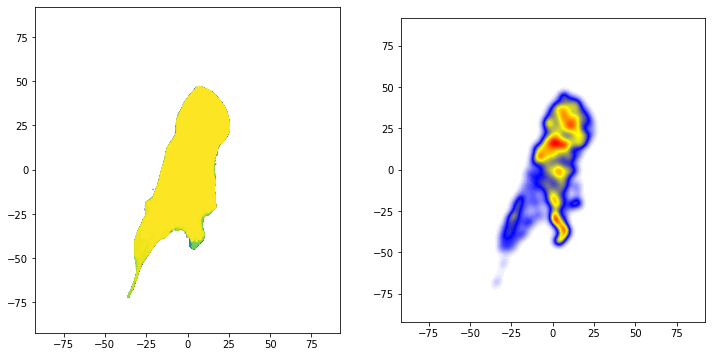

In [6]:
# load all the embeddings
list_ally = []
for i in glob.glob(parameters.projectPath+'/Projections/*_%s.mat'%(zValstr)):
    list_ally.append(hdf5storage.loadmat(i)['zValues'])
ally = np.concatenate(list_ally)
m = np.abs(ally).max()

sigma=2.0
_, xx, density = mmpy.findPointDensity(ally, sigma, 511, [-m-20, m+20])


fig, axes = plt.subplots(1, 2, figsize=(12,6))
axes[0].scatter(ally[:,0], ally[:,1], marker='.', c=np.arange(ally.shape[0]), s=1)
axes[0].set_xlim([-m-20, m+20])
axes[0].set_ylim([-m-20, m+20])

axes[1].imshow(density, cmap=mmpy.gencmap(), extent=(xx[0], xx[-1], xx[0], xx[-1]), origin='lower')

In [ ]:
startsigma = 4.2 if parameters.method == 'TSNE' else 1.0
mmpy.findWatershedRegions(parameters, minimum_regions=5, startsigma=startsigma, pThreshold=[0.33, 0.67],
                     saveplot=True, endident = '*_pcaModes.mat')

from IPython.display import Image
Image(glob.glob('%s/%s/zWshed*.png'%(parameters.projectPath, parameters.method))[0])

In [33]:
wshedfile["watershedRegions"].shape, wshedfile['zValues'].shape

((1, 91704144), (91704144, 2))

In [ ]:
wshedfile

In [ ]:
wshedfile = hdf5storage.loadmat('%s/%s/zVals_wShed_groups.mat'%(parameters.projectPath, parameters.method))
from time import gmtime, strftime
def ethnogram_of_clusters(clusters, start_idx=0, fish_key="", day="", write_fig=False):
    offset = start_idx
    len_s = clusters.size
    f2min = (60**2)*5
    rows = 4
    len_half = len_s//rows
    step = len_half//10
    wregs = clusters[offset:offset+len_s]
    ethogram = np.zeros((wregs.max(), len(wregs)))

    for wreg in range(1, wregs.max()+1):
        ethogram[wreg-1, np.where(wregs==wreg)[0]] = 1.0

    ethogram = np.split(ethogram.T, np.array([len_half*i for i in range(1,rows)]))

    fig, axes = plt.subplots(rows, 1, figsize=(30,3*rows))
    axes[0].set_title(f"{fish_key} {day}")
    for k, (e, ax) in enumerate(zip(ethogram, axes.flatten())):
        ax.imshow(e.T, aspect='auto', cmap=mmpy.gencmap())
        ax.set_yticks([i for i in range(0, wregs.max(), 1)])
        ax.set_yticklabels(['Region %i'%(j+1) for j in range(0, wregs.max(), 1)])
        xticklocs = [i for i in range(0,len_half, step)]
        ax.set_xticks(xticklocs)
        ax.set_xticklabels([strftime("%H:%M", gmtime((j+(k*len_half))//5)) for j in xticklocs])

    ax.set_xlabel('Time (H:M)')
    if write_fig:
        path_e = f"{VIS_DIR}/{BLOCK}_ethograms"
        if not os.path.exists(path_e):
            os.mkdir(path_e)
        fig.savefig(f"{path_e}/ethogram_{fish_key}_{day}.pdf")
    return fig

for d in get_days_in_order(camera=fk.split("_")[0], is_back=fk.split("_")[1]==BACK):
    clusters = get_regions_for_fish_key(fk,wshedfile, day=d)
    if clusters is not None:
        f = ethnogram_of_clusters(clusters, fish_key=fk, day=d, write_fig=True)
        plt.close(f)

In [7]:

t = transition_rates(get_regions_for_fish_key(fk, wshedfile)-1)
draw_transition_graph(t, 5, pointsInCircum(1,5))

(5, 5)


RuntimeError: Gtk couldn't be initialized. Use Gtk.init_check() if you want to handle this case.

In [20]:
import graph_tool as gt
g = gt.collection.data["celegansneural"]
state = gt.minimize_nested_blockmodel_dl(g)
gt.draw_hierarchy(state, output="celegansneural_nested_mdl.pdf")

AttributeError: module 'graph_tool' has no attribute 'collection'

In [29]:
gt.collection

AttributeError: module 'graph_tool' has no attribute 'collection'

In [4]:
# Python standard library packages to do file/folder manipulations,
# pickle is a package to store python variables
import glob, os, pickle, sys

# time grabs current clock time and copy to safely make copies of large 
# variables in memory.
import time, copy 

# datetime package is used to get and manipulate date and time data
from datetime import datetime

# this packages helps load and save .mat files older than v7
import hdf5storage, h5py

# numpy works with arrays, pandas used to work with fancy numpy arrays
import numpy as np
import pandas as pd

# matplotlib is used to plot and animate to make movies
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# moviepy helps open the video files in Python
from moviepy.editor import VideoClip, VideoFileClip
from moviepy.video.io.bindings import mplfig_to_npimage

# Scikit-learn is a go-to library in Python for all things machine learning
from sklearn.decomposition import PCA

# tqdm helps create progress bars in for loops 
from tqdm import tqdm 

# Scipy is a go-to scientific computing library. We'll use it for median filtering. 
from scipy.ndimage import median_filter

# Configuring matplotlib to show animations in a colab notebook as javascript 
# objects for easier viewing. 
from matplotlib import rc
rc('animation', html='jshtml')

In [53]:
index_fk = np.where([(fish_keys[4] in file.flatten()[0]) for file in wshedfile['zValNames'][0]])[0]

In [54]:
wshedfile['zValLens'].flatten().cumsum()[[index_fk[0], index_fk[-1]]]

array([13335729, 19776088])

In [9]:
fk = fish_keys[5]
fk_X = load_trajectory_data(fk, parameters, day=day)[0]

In [10]:
fk_X_zVals = load_zVals(fk, parameters, day=day)[0]

In [11]:
clusters = get_regions_for_fish_key(fk, wshedfile, day=day)

In [46]:
from random import sample
def plot_lines_for_cluster(
    positions,
    projections,
    area,
    clusters,
    n_clusters,
    limit=20,
    fig_name="cluster_characteristics.pdf",
):
    nrows = 2
    fig, axs = plt.subplots(
        nrows=nrows, ncols=n_clusters, figsize=(n_clusters * 4, nrows * 4), sharey="row"
    )
    for cluster_id in range(1,n_clusters+1):
        ax_b = axs[1, cluster_id-1]
        ax = axs[0, cluster_id-1]
        boxplot_characteristics_of_cluster(projections[clusters == cluster_id], ax_b, metric_names=["speed x", "speed y", "angle"])
        samples_c_idx = np.where(clusters == cluster_id)[0]
        cluster_share = samples_c_idx.shape[0] / projections.shape[0]
        select = sample(range(len(samples_c_idx)), k=limit)
        plot_lines_select(
            positions,
            samples_c_idx[select],
            area, 
            ax=ax,
            title="cluster: %d,      share: %.2f" % (cluster_id, cluster_share),
        )
        ax_b.yaxis.set_tick_params(which="both", labelbottom=True)

    fig.savefig(get_results_filepath(1, fig_name), bbox_inches="tight")
    plt.close(fig)
    
def plot_lines_select(positions, samples_idx, area, ax, title):
    ax.set_title(title)
    plot_area(area, ax)
    for idx in samples_idx:
        s,t = max(idx-50,0),min(idx+50, len(positions)-1)
        ax.plot(positions[s:t, 0], positions[s:t, 1])

def plot_area(area_box, ax):
    area_box = np.concatenate((area_box, [area_box[0]]))
    ax.plot(*area_box.T)

In [47]:
plot_lines_for_cluster(fk_X["positions"], fk_X['projections'],fk_X["area"], clusters, 5)

In [49]:
#wshedfile = hdf5storage.loadmat('%s/%s/zVals_wShed_groups.mat'%(parameters.projectPath, parameters.method))

try:
    tqdm._instances.clear()
except:
    pass

#data 
zValues = fk_X_zVals['zValues']
traj_data = fk_X['positions']
#clusterer =hdbscan.HDBSCAN(min_samples=5,min_cluster_size=trainy.shape[0]//100)
#clusters = get_regions_for_fish_key(fish_keys[4], wshedfile)#clusterer.fit_predict(zValues)
area_box = fk_X['area']

fig, axes = plt.subplots(1, 2, figsize=(10,5))
tfolder = parameters.projectPath+'/%s/'%parameters.method
with h5py.File(tfolder + 'training_embedding.mat', 'r') as hfile:
    trainingEmbedding = hfile['trainingEmbedding'][:].T
#    trainingEmbedding = np.concatenate([trainingEmbedding,zValues[:len(trainingEmbedding)]])
#trainingEmbedding = np.concatenate([fk_zV['zValues'] for fk_zV in fk_X_zVals])
print("trainingEmbedding: ", trainingEmbedding.shape)
m = np.abs(trainingEmbedding).max()


sigma=1.0
_, xx, density = mmpy.findPointDensity(trainingEmbedding, sigma, 511, [-m-10, m+10])
axes[0].imshow(density, cmap=mmpy.gencmap(), extent=(xx[0], xx[-1], xx[0], xx[-1]), origin='lower')
axes[0].axis('off')
axes[0].set_title('Method : %s'%parameters.method)
sc = axes[0].scatter([],[],marker='o', c="b", s=300)

area_box = np.concatenate((area_box, [area_box[0]]))
axes[1].plot(*area_box.T)
(line,) = axes[1].plot([],[], "-o")

h5ind = 3
tstart = 0

def animate(t):
    t = int(t*100)+tstart
    line.set_data(*traj_data[20000*h5ind+t-100:20000*h5ind+t+100].T)
    axes[1].axis('off')
    axes[0].set_title('Method : %s seconds: %s'%(parameters.method, t//5))
    sc.set_offsets(zValues[20000*h5ind+t])
    sc.set_color(get_color(clusters[20000*h5ind+t]))
    return mplfig_to_npimage(fig) #im, ax

def get_color(ci):
    color = ['lightcoral', 'darkorange', 'olive', 'teal', 'violet', 
         'skyblue']
    return color[ci%len(color)]

anim = VideoClip(animate, duration=20) # will throw memory error for more than 100.
plt.close()
anim.ipython_display(fps=10, loop=True, autoplay=True, maxduration=120)


trainingEmbedding:  (9750, 2)
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [20]:
len(fk_X_zVals)

27

In [16]:
len(fk_X)

27

In [36]:
zValues_list = []
for i in glob.glob(parameters.projectPath+'/Projections/*_%s.mat'%(zValstr)):
    zValues_list.append(hdf5storage.loadmat(i)['zValues'])
zValues_concat = np.concatenate(zValues_list)

In [38]:
zValues_concat.shape

(430489, 2)